In this notebook, we will work through the vanishing gradients problem through several visualizations. We will look at a few ways to address this problem and understand them through visualizations.

### Imports

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [3]:
np.random.seed(0)

### Generating data

In [4]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D), dtype='float32') # data matrix (each row = single example)
y = np.zeros(N*K, dtype='int32') # class labels

In [5]:
for j in xrange(K):
    indices = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[indices] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[indices] = j

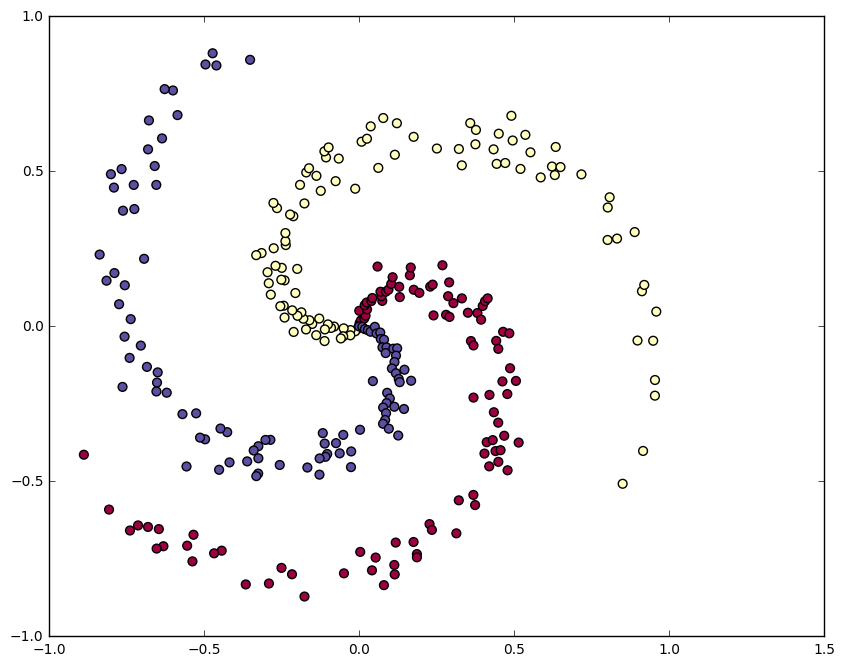

In [6]:
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

#### Let's first design and implement a Multi-Layer Neural Network class.
#### It takes number of layers and hidden nodes as some of its parameters

In [7]:
# An utility function to compute the sigmoid activation
def sigmoid(scores):
    probas = 1/(1+np.exp(-scores))
    return probas
# An utility function to compute the softmax
def softmax(scores):
    #shift the values of scores so that the highest number is 0 - avoids numerical blowup while exponentiating
    max_zero_scores = scores - np.max(scores)
    exp_scores = np.exp(scores)
    probas = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probas
# An utility function to compute the ReLU activation
def relu(scores):
    scores[scores <= 0] = 0
    return scores
# An utility function to compute the sigmoid gradient
def sigmoid_gradient(scores):
    return scores * (1-scores)

In [8]:
class MultiLayerSGDNeuralNetwork(object):
    def __init__(self, input_shape, labels_shape, num_classes,
             num_hidden_nodes, num_iterations=10000, learning_rate=1e-0, 
             reg_constant=1e-3, W_init_type='Glorot', sigma_W_init=0.1,
             activation_function='relu', track_gradients=False, track_weights=False):
        # initialize parameters of the network
        self.num_examples = input_shape[0]
        self.num_classes = num_classes
        self.num_hidden_layers = num_hidden_nodes.shape[0]
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.reg_constant = reg_constant
        self.activation_function = activation_function
        self.track_gradients = track_gradients
        self.track_weights = track_weights
        
        self.params = {}
        
        if self.track_gradients:
            self.params['dW_init_history'] = []
            for i in range(self.num_hidden_layers):
                self.params['dWh_'+str(i+1)+'_history'] = []
                self.params['dh_'+str(i+1)+'_history'] = []
                
        if self.track_weights:
            self.params['W_init_history'] = []
            for i in range(self.num_hidden_layers):
                self.params['Wh_'+str(i+1)+'_history'] = []
        
        # Glorot/Xavier initialization
        if W_init_type == 'glorot':
            if len(num_hidden_nodes):
                sigma_W_init = np.sqrt(float(2)/(input_shape[1]+num_hidden_nodes[0]))
                self.params['W_init'] = sigma_W_init * np.random.randn(input_shape[1],num_hidden_nodes[0])
                self.params['b_init'] = np.zeros((1,num_hidden_nodes[0]))
                
                for i in range(self.num_hidden_layers):
                    if i == self.num_hidden_layers - 1:
                        sigma_Wh = np.sqrt(float(2)/(num_hidden_nodes[i]+num_classes))
                        self.params['Wh_'+str(i+1)] = sigma_Wh * np.random.randn(num_hidden_nodes[i],num_classes)
                        self.params['bh_'+str(i+1)] = np.zeros((1,num_classes))
                    else:
                        sigma_Wh = np.sqrt(float(2)/(num_hidden_nodes[-1]+num_hidden_nodes[-1]))
                        self.params['Wh_'+str(i+1)] = sigma_Wh * np.random.randn(num_hidden_nodes[-1],num_hidden_nodes[-1])
                        self.params['bh_'+str(i+1)] = np.zeros((1,num_hidden_nodes[-1]))
            else:
                sigma_W_init = np.sqrt(float(2)/(input_shape[1]+num_classes))
                self.params['W_init'] = sigma_W_init * np.random.randn(input_shape[1],num_classes)
                self.params['b_init'] = np.zeros((1,num_classes))

        # Kaiming initialization
        elif W_init_type == 'kaiming':
            if len(num_hidden_nodes):
                sigma_W_init = np.sqrt(float(2)/input_shape[1])
                self.params['W_init'] = sigma_W_init * np.random.randn(input_shape[1],num_hidden_nodes[0])
                self.params['b_init'] = np.zeros((1,num_hidden_nodes[0]))

                for i in range(self.num_hidden_layers):
                    if i == self.num_hidden_layers - 1:
                        sigma_Wh = np.sqrt(float(2)/num_hidden_nodes[i])
                        self.params['Wh_'+str(i+1)] = sigma_Wh * np.random.randn(num_hidden_nodes[i],num_classes)
                        self.params['bh_'+str(i+1)] = np.zeros((1,num_classes))
                    else:
                        sigma_Wh = np.sqrt(float(2)/num_hidden_nodes[-1])
                        self.params['Wh_'+str(i+1)] = sigma_Wh * np.random.randn(num_hidden_nodes[-1],num_hidden_nodes[-1])
                        self.params['bh_'+str(i+1)] = np.zeros((1,num_hidden_nodes[-1]))
            else:
                sigma_W_init = np.sqrt(float(2)/(input_shape[1]))
                self.params['W_init'] = sigma_W_init * np.random.randn(input_shape[1],num_classes)
                self.params['b_init'] = np.zeros((1,num_classes))
                
        # all zero initialization
        elif W_init_type == 'zeros':
            if len(num_hidden_nodes):
                self.params['W_init'] = 0 * np.random.randn(input_shape[1],num_hidden_nodes[0])
                self.params['b_init'] = np.zeros((1,num_hidden_nodes[0]))

                for i in range(self.num_hidden_layers):
                    if i == self.num_hidden_layers - 1:
                        sigma_Wh = np.sqrt(float(2)/num_hidden_nodes[i])
                        self.params['Wh_'+str(i+1)] = 0 * np.random.randn(num_hidden_nodes[i],num_classes)
                        self.params['bh_'+str(i+1)] = np.zeros((1,num_classes))
                    else:
                        sigma_Wh = np.sqrt(float(2)/num_hidden_nodes[-1])
                        self.params['Wh_'+str(i+1)] = 0 * np.random.randn(num_hidden_nodes[-1],num_hidden_nodes[-1])
                        self.params['bh_'+str(i+1)] = np.zeros((1,num_hidden_nodes[-1]))
            else:
                self.params['W_init'] = 0 * np.random.randn(input_shape[1],num_classes)
                self.params['b_init'] = np.zeros((1,num_classes))
        
        # a custom initialization with 0.05 sigma from a normal distribution
        elif W_init_type == '0.05_sigma':
            if len(num_hidden_nodes):
                self.params['W_init'] = 0.05 * np.random.randn(input_shape[1],num_hidden_nodes[0])
                self.params['b_init'] = np.zeros((1,num_hidden_nodes[0]))

                for i in range(self.num_hidden_layers):
                    if i == self.num_hidden_layers - 1:
                        self.params['Wh_'+str(i+1)] = 0.05 * np.random.randn(num_hidden_nodes[i],num_classes)
                        self.params['bh_'+str(i+1)] = np.zeros((1,num_classes))
                    else:
                        self.params['Wh_'+str(i+1)] = 0.05 * np.random.randn(num_hidden_nodes[-1],num_hidden_nodes[-1])
                        self.params['bh_'+str(i+1)] = np.zeros((1,num_hidden_nodes[-1]))
            else:
                self.params['W_init'] = 0.05 * np.random.randn(input_shape[1],num_classes)
                self.params['b_init'] = np.zeros((1,num_classes))
        
        self.num_iterations = num_iterations
        
    def compute_scores_and_loss(self, X, y):
        # compute the loss: average cross-entropy loss and regularization
        
        # evaluate class scores
        # Forward pass
        scores_list = []
        for i in range(self.num_hidden_layers+1):    
            if i == 0:
                hidden_scores = np.dot(X, self.params['W_init']) + self.params['b_init']
                if self.activation_function == 'relu' and self.num_hidden_layers != 0:
                    # compute the relu activations
                    hidden_scores = relu(hidden_scores)
                elif self.activation_function == 'sigmoid' or self.num_hidden_layers == 0:
                    # compute the sigmoid/softmax activations
                    hidden_scores = sigmoid(hidden_scores)
                    
                scores_list.append(hidden_scores)
            else:        
                scores = np.dot(scores_list[i-1], self.params['Wh_'+str(i)]) + self.params['bh_'+str(i)]
                if i != self.num_hidden_layers:    
                    if self.activation_function == 'relu':
                        # compute the relu activations
                        scores = relu(scores)
                    elif self.activation_function == 'sigmoid':
                        scores = sigmoid(scores)
                else:
                    # the last layer is always softmax
                    scores = sigmoid(scores)
                scores_list.append(scores)
        
        final_probas = scores_list[-1]
        correct_logprobs = -np.log(final_probas[range(self.num_examples),y])
        data_loss = np.sum(correct_logprobs)/self.num_examples
        
        reg_loss = 0.5*self.reg_constant*np.sum(self.params['W_init']*self.params['W_init'])
        for i in range(self.num_hidden_layers): 
            reg_loss += 0.5*self.reg_constant*np.sum(self.params['Wh_'+str(i+1)]*self.params['Wh_'+str(i+1)])
            
        loss = data_loss + reg_loss
        return scores_list, final_probas, loss
    
    def __compute_gradients(self, X, y, final_probas, scores_list):
        num_examples = self.num_examples
        
        # Compute the gradient on scores
        dscores = final_probas
        dscores[range(num_examples),y] -= 1
        dscores /= num_examples
 
        # Back Propagation
        if self.num_hidden_layers == 0:
            # backpropagate the gradient to the first layer
            self.params['dW_init'] =  np.dot(X.T, dscores)
            self.params['db_init'] = np.sum(dscores, axis=0, keepdims=True)

            # add regularization
            self.params['dW_init'] += self.reg_constant*self.params['W_init']
        else:
            for i in range(self.num_hidden_layers+1):
                idx = self.num_hidden_layers-i
                if idx == 0:
                    # backpropagate the gradient to the first layer
                    self.params['dW_init'] =  np.dot(X.T, self.params['dh_1'])
                    self.params['db_init'] = np.sum(self.params['dh_1'], axis=0, keepdims=True)

                    # add regularization
                    self.params['dW_init'] += self.reg_constant*self.params['W_init']
                elif idx == self.num_hidden_layers:
                    # backpropagate the gradient from the final layer
                    self.params['dWh_'+str(idx)] = (scores_list[idx-1].T).dot(dscores)
                    self.params['dbh_'+str(idx)] = np.sum(dscores, axis=0, keepdims=True)
                    self.params['dh_'+str(idx)] = np.dot(dscores, self.params['Wh_'+str(idx)].T)
                    if self.activation_function == 'relu':
                        # backpropagate through ReLU nonlinearity
                        self.params['dh_'+str(idx)][scores_list[idx-1] <= 0] = 0
                    elif self.activation_function == 'sigmoid':
                        # backpropagate through sigmoid nonlinearity
                        self.params['dh_'+str(idx)] = self.params['dh_'+str(idx)] * sigmoid_gradient(scores_list[idx-1])
                    # add regularization
                    self.params['dWh_'+str(idx)] += self.reg_constant*self.params['Wh_'+str(idx)]
                else:
                    # backpropagate the gradient to the hidden layer
                    self.params['dWh_'+str(idx)] =  np.dot( scores_list[idx-1].T, self.params['dh_'+str(idx+1)])
                    self.params['dbh_'+str(idx)] = np.sum(self.params['dh_'+str(idx+1)], axis=0, keepdims=True)
                    self.params['dh_'+str(idx)] = np.dot(self.params['dh_'+str(idx+1)], self.params['Wh_'+str(idx)].T)
                    if self.activation_function == 'relu':
                        # backpropagate through ReLU nonlinearity
                        self.params['dh_'+str(idx)][scores_list[idx-1] <= 0] = 0
                    elif self.activation_function == 'sigmoid':
                        # backpropagate through sigmoid nonlinearity
                        self.params['dh_'+str(idx)] = self.params['dh_'+str(idx)] * sigmoid_gradient(scores_list[idx-1])
                    # add regularization
                    self.params['dWh_'+str(idx)] += self.reg_constant*self.params['Wh_'+str(idx)]
    def fit(self, X, y):
        losses = []
        # stochastic gradient descent loop
        for i in xrange(self.num_iterations):
            scores_list, final_probas, loss = self.compute_scores_and_loss(X,y)
            if i % 1000 == 0:
                print "iteration %d: loss %f" % (i, loss)
                losses.append(loss)

            # compute gradients through backprop
            self.__compute_gradients(X,y,final_probas,scores_list)
            
            # perform a parameter update for the first layer
            self.params['W_init'] += -self.learning_rate * self.params['dW_init']
            self.params['b_init'] += -self.learning_rate * self.params['db_init']
            if self.track_gradients:
                self.params['dW_init_history'].append(self.params['dW_init'])
            if self.track_weights:
                self.params['W_init_history'].append(self.params['W_init'])
            
            # perform a parameter update for hidden layers
            for i in range(self.num_hidden_layers):
                self.params['Wh_'+str(i+1)] += -self.learning_rate * self.params['dWh_'+str(i+1)]
                self.params['bh_'+str(i+1)] += -self.learning_rate * self.params['dbh_'+str(i+1)]
                if self.track_gradients:
                    self.params['dWh_'+str(i+1)+'_history'].append(self.params['dWh_'+str(i+1)])
                if self.track_weights:
                    self.params['Wh_'+str(i+1) + '_history'].append(self.params['Wh_'+str(i+1)])
        self.losses = losses

    def accuracy(self,X,y):
        final_scores = []
        for i in range(self.num_hidden_layers+1):    
            if i == 0:
                hidden_scores = np.dot(X, self.params['W_init']) + self.params['b_init']
                if self.activation_function == 'relu':
                    # compute the relu activations
                    hidden_scores = relu(hidden_scores)
                elif self.activation_function == 'sigmoid':
                    hidden_scores = sigmoid(hidden_scores)
                final_scores.append(hidden_scores)
            else:
                scores = np.dot(final_scores[i-1], self.params['Wh_'+str(i)]) + self.params['bh_'+str(i)]
                if i != self.num_hidden_layers:    
                    if self.activation_function == 'relu':
                        # compute the relu activations
                        scores = relu(scores)
                    elif self.activation_function == 'sigmoid':
                        scores = sigmoid(scores)
                final_scores.append(scores)
        predicted_class = np.argmax(final_scores[-1], axis=1)
        print 'training accuracy: %.2f' % (np.mean(predicted_class == y)) 

### An instance of numerical overflow issues with softmax

The cell below is just for illustration purposes. Executing this might throw an error

One might encounter an overflow exception if care is not taken during exponentiating scores. One trick is to make the maximum score zero by subtracting it from each individual score. This is done in the code above.

In [101]:
#sgd_2layer = SGDNeuralNetwork(input_dim=(N*K,D), num_classes=K)
#sgd_2layer.fit(X,y)

iteration 0: loss 4.606189
iteration 1000: loss 2.181300


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in less_equal


iteration 2000: loss nan
iteration 3000: loss nan
iteration 4000: loss nan
iteration 5000: loss nan
iteration 6000: loss nan


KeyboardInterrupt: 

### Let's train some neural networks

In [9]:
sgd_0layer_custom_init_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([]), learning_rate=1e-1, num_iterations=25000,
                            W_init_type='0.05_sigma', activation_function='sigmoid', track_gradients=True,
                                                           track_weights=True)
sgd_0layer_custom_init_sigmoid.fit(X,y)

iteration 0: loss 0.688941
iteration 1000: loss 0.811730
iteration 2000: loss 0.810982
iteration 3000: loss 0.811477
iteration 4000: loss 0.811644
iteration 5000: loss 0.811692
iteration 6000: loss 0.811705
iteration 7000: loss 0.811709
iteration 8000: loss 0.811710
iteration 9000: loss 0.811710
iteration 10000: loss 0.811711
iteration 11000: loss 0.811711
iteration 12000: loss 0.811711
iteration 13000: loss 0.811711
iteration 14000: loss 0.811711
iteration 15000: loss 0.811711
iteration 16000: loss 0.811711
iteration 17000: loss 0.811711
iteration 18000: loss 0.811711
iteration 19000: loss 0.811711
iteration 20000: loss 0.811711
iteration 21000: loss 0.811711
iteration 22000: loss 0.811711
iteration 23000: loss 0.811711
iteration 24000: loss 0.811711


### Evaluate

In [10]:
sgd_0layer_custom_init_sigmoid.accuracy(X,y)

training accuracy: 0.49


### How about 1 hidden layer?

In [11]:
sgd_1layer_custom_init_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]), learning_rate=1e-1, num_iterations=25000,
                                W_init_type='0.05_sigma', activation_function='sigmoid', track_gradients=True,
                                                           track_weights=True)
sgd_1layer_custom_init_sigmoid.fit(X,y)
sgd_1layer_custom_init_sigmoid.accuracy(X,y)

iteration 0: loss 0.723120
iteration 1000: loss 0.886461
iteration 2000: loss 0.826314
iteration 3000: loss 0.824958
iteration 4000: loss 0.823632
iteration 5000: loss 0.821847
iteration 6000: loss 0.818851
iteration 7000: loss 0.812578
iteration 8000: loss 0.800006
iteration 9000: loss 0.781628
iteration 10000: loss 0.764107
iteration 11000: loss 0.752566
iteration 12000: loss 0.746737
iteration 13000: loss 0.744073
iteration 14000: loss 0.741933
iteration 15000: loss 0.738095
iteration 16000: loss 0.731524
iteration 17000: loss 0.723374
iteration 18000: loss 0.716353
iteration 19000: loss 0.712232
iteration 20000: loss 0.710935
iteration 21000: loss 0.711515
iteration 22000: loss 0.713041
iteration 23000: loss 0.714884
iteration 24000: loss 0.716688
training accuracy: 0.93


### 2 hidden layers??

In [12]:
sgd_2layer_custom_init_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50,50]), learning_rate=1e-1, num_iterations=25000,
                                W_init_type='0.05_sigma', activation_function='sigmoid', track_gradients=True,
                                                           track_weights=True)
sgd_2layer_custom_init_sigmoid.fit(X,y)
sgd_2layer_custom_init_sigmoid.accuracy(X,y)

iteration 0: loss 0.709788
iteration 1000: loss 1.100923
iteration 2000: loss 1.100240
iteration 3000: loss 1.099136
iteration 4000: loss 1.093050
iteration 5000: loss 0.963359
iteration 6000: loss 0.934183
iteration 7000: loss 0.851165
iteration 8000: loss 0.840622
iteration 9000: loss 0.838438
iteration 10000: loss 0.836146
iteration 11000: loss 0.832858
iteration 12000: loss 0.825286
iteration 13000: loss 0.799956
iteration 14000: loss 0.751232
iteration 15000: loss 0.714069
iteration 16000: loss 0.684708
iteration 17000: loss 0.651840
iteration 18000: loss 0.629525
iteration 19000: loss 0.622294
iteration 20000: loss 0.622123
iteration 21000: loss 0.623851
iteration 22000: loss 0.625711
iteration 23000: loss 0.627232
iteration 24000: loss 0.628353
training accuracy: 0.97


### 3 hidden layers??

In [13]:
sgd_3layer_custom_init_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*3), learning_rate=1e-1, num_iterations=25000,
                            W_init_type='0.05_sigma', activation_function='sigmoid', track_gradients=True,
                                                           track_weights=True)
sgd_3layer_custom_init_sigmoid.fit(X,y)
sgd_3layer_custom_init_sigmoid.accuracy(X,y)

iteration 0: loss 0.782444
iteration 1000: loss 1.103796
iteration 2000: loss 1.102840
iteration 3000: loss 1.102058
iteration 4000: loss 1.101417
iteration 5000: loss 1.100893
iteration 6000: loss 1.100464
iteration 7000: loss 1.100113
iteration 8000: loss 1.099825
iteration 9000: loss 1.099589
iteration 10000: loss 1.099396
iteration 11000: loss 1.099239
iteration 12000: loss 1.099109
iteration 13000: loss 1.099003
iteration 14000: loss 1.098917
iteration 15000: loss 1.098846
iteration 16000: loss 1.098788
iteration 17000: loss 1.098741
iteration 18000: loss 1.098702
iteration 19000: loss 1.098670
iteration 20000: loss 1.098645
iteration 21000: loss 1.098623
iteration 22000: loss 1.098606
iteration 23000: loss 1.098592
iteration 24000: loss 1.098581
training accuracy: 0.33


### Let's go "Deep"er - 6 hidden layers

In [14]:
sgd_6layer_custom_init_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*6), learning_rate=1e-1, num_iterations=25000,
                            W_init_type='0.05_sigma', activation_function='sigmoid', track_gradients=True,
                                                           track_weights=True)
sgd_6layer_custom_init_sigmoid.fit(X,y)
sgd_6layer_custom_init_sigmoid.accuracy(X,y)

iteration 0: loss 0.781945
iteration 1000: loss 1.111407
iteration 2000: loss 1.109072
iteration 3000: loss 1.107159
iteration 4000: loss 1.105594
iteration 5000: loss 1.104312
iteration 6000: loss 1.103263
iteration 7000: loss 1.102404
iteration 8000: loss 1.101700
iteration 9000: loss 1.101125
iteration 10000: loss 1.100653
iteration 11000: loss 1.100267
iteration 12000: loss 1.099952
iteration 13000: loss 1.099693
iteration 14000: loss 1.099482
iteration 15000: loss 1.099308
iteration 16000: loss 1.099167
iteration 17000: loss 1.099051
iteration 18000: loss 1.098956
iteration 19000: loss 1.098878
iteration 20000: loss 1.098815
iteration 21000: loss 1.098763
iteration 22000: loss 1.098720
iteration 23000: loss 1.098686
iteration 24000: loss 1.098657
training accuracy: 0.33


#### OOPS!! We were better with no hidden layers :D

#### Alright. There's clearly something going on here. The performance is getting worse as the number of layers increase.


#### It's always helpful to visualize the intermediate parameters to get some intuition on what's going on.

### Let's visualize some stuff

Credit to https://github.com/hack1nt0/DLNLP/blob/master/lecture/Suggested%20Readings/7/vanishing_grad_example.ipynb

In [15]:
# An utility function to sum and normalize gradients for a parameter
def normalize_gradient_sum(dW):
    return np.sum(np.abs(dW), axis=(1,2))/np.sum(np.abs(dW.shape[1:]))

In [16]:
def plot_gradients(models,model_names=None,layer_indices=None,axes_limits=[],custom_legend=[],title='Sum of magnitudes of gradients'):
    legend = []
    if model_names is None:
        model_names = [str(model.num_hidden_layers) + " layer" for model in models]
    for model_i, model in enumerate(models):
        num_hidden_layers = model.num_hidden_layers
        if layer_indices is None:
            layer_indices = range(num_hidden_layers)
        dW_init = np.array(model.params['dW_init_history'])
        dW_list = [normalize_gradient_sum(dW_init)]
        for i in range(num_hidden_layers):
            dW_list.append(normalize_gradient_sum(np.array(model.params['dWh_'+str(i+1)+'_history'])))
        sliced_dW_list = np.array(dW_list)[layer_indices]
        for i, gradients in enumerate(sliced_dW_list):
            plt.plot(np.array(gradients))
            legend.append(model_names[model_i] + " model & Layer "+ str(layer_indices[i]+1) + " weights' gradients")
    if len(axes_limits):
        plt.axis(axes_limits)
    plt.title(title)
    if len(custom_legend):
        plt.legend(custom_legend)
    else:
        plt.legend(legend)
    plt.xlabel("Number of iterations")
    plt.ylabel("Sum of gradients")

### Plot gradients for all layers of a single model

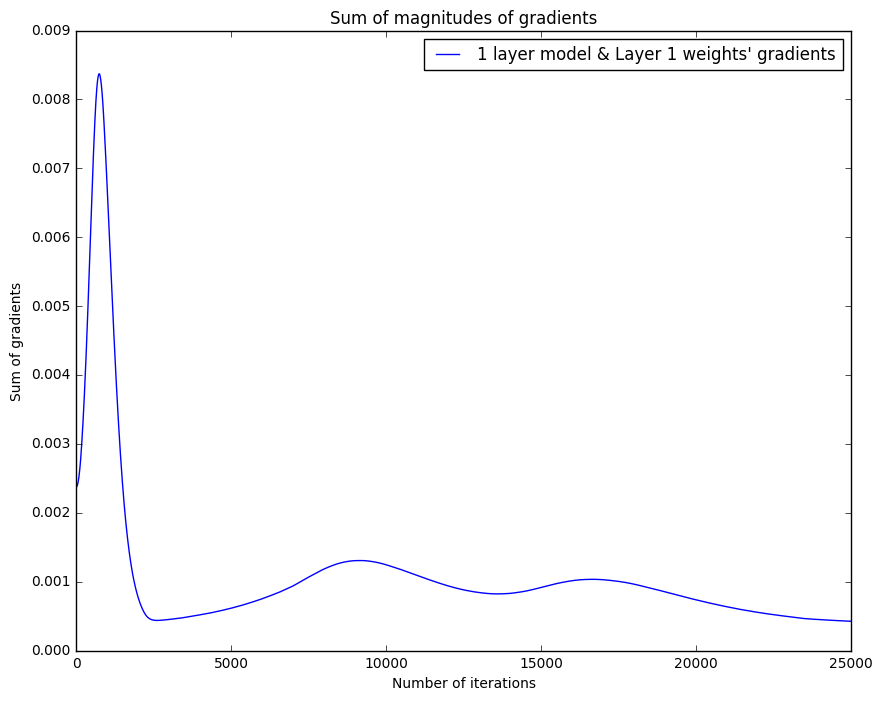

In [17]:
plot_gradients(models=[sgd_1layer_custom_init_sigmoid])

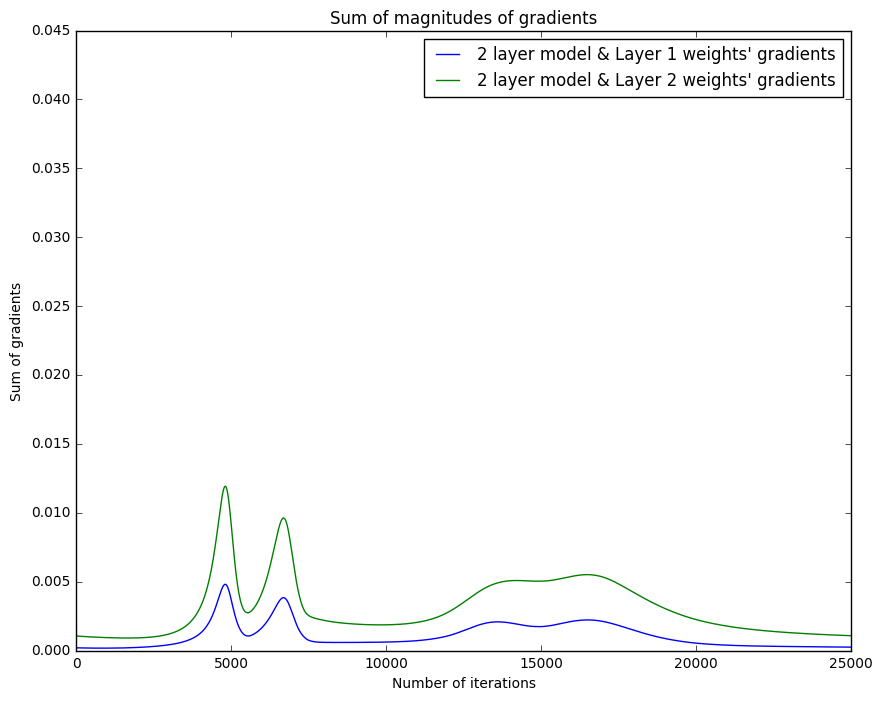

In [18]:
plot_gradients(models=[sgd_2layer_custom_init_sigmoid])

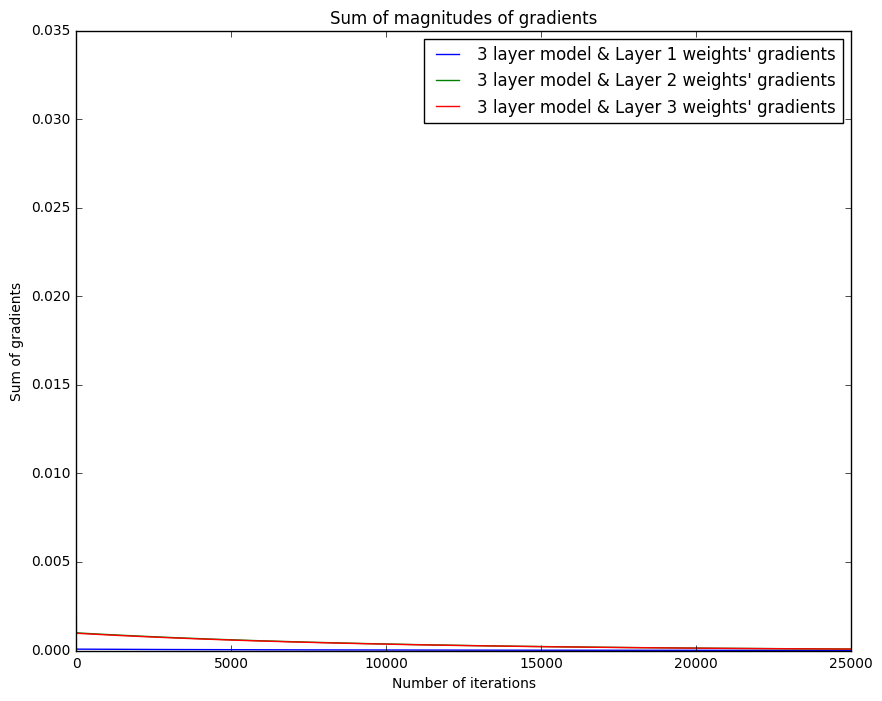

In [19]:
plot_gradients(models=[sgd_3layer_custom_init_sigmoid])

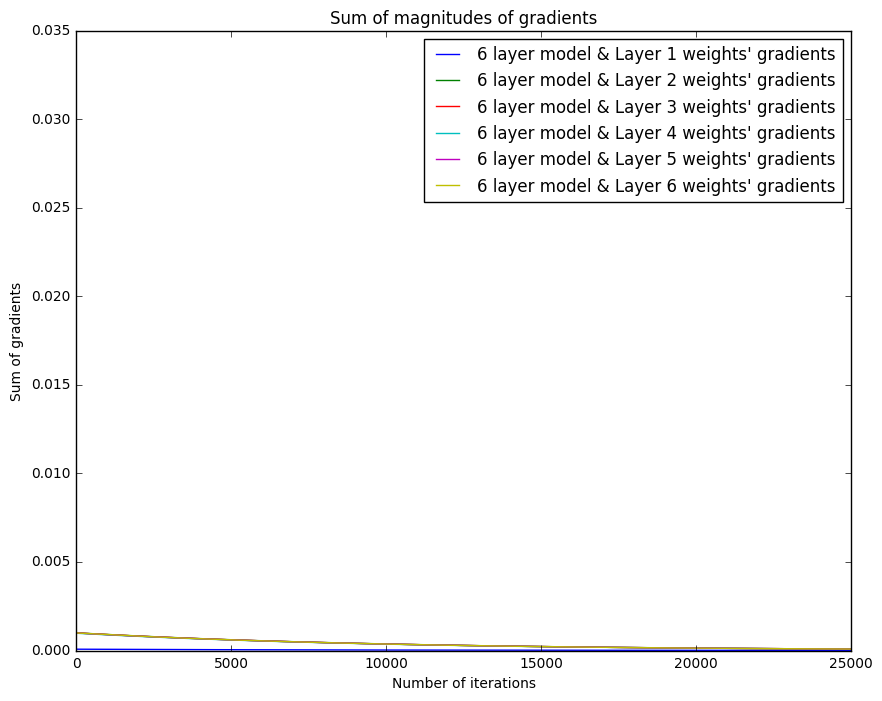

In [20]:
plot_gradients(models=[sgd_6layer_custom_init_sigmoid])

### Let's zoom in a bit

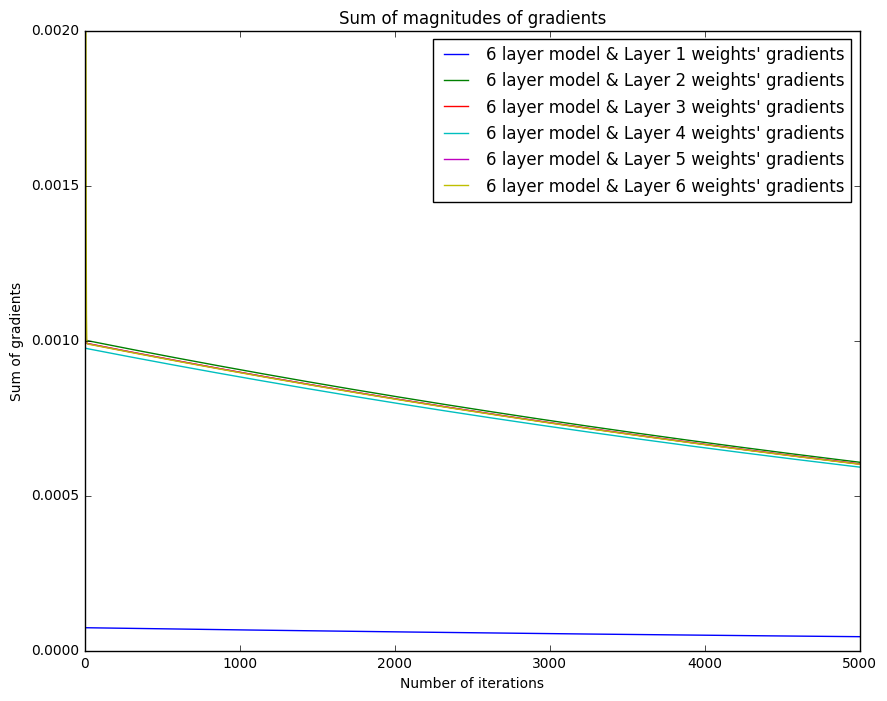

In [21]:
plot_gradients(models=[sgd_6layer_custom_init_sigmoid], axes_limits=[0,5000,0,0.002])

### Plot gradients for specified layers across different models

#### Here, we are plotting the gradients for the first layer for all our above models

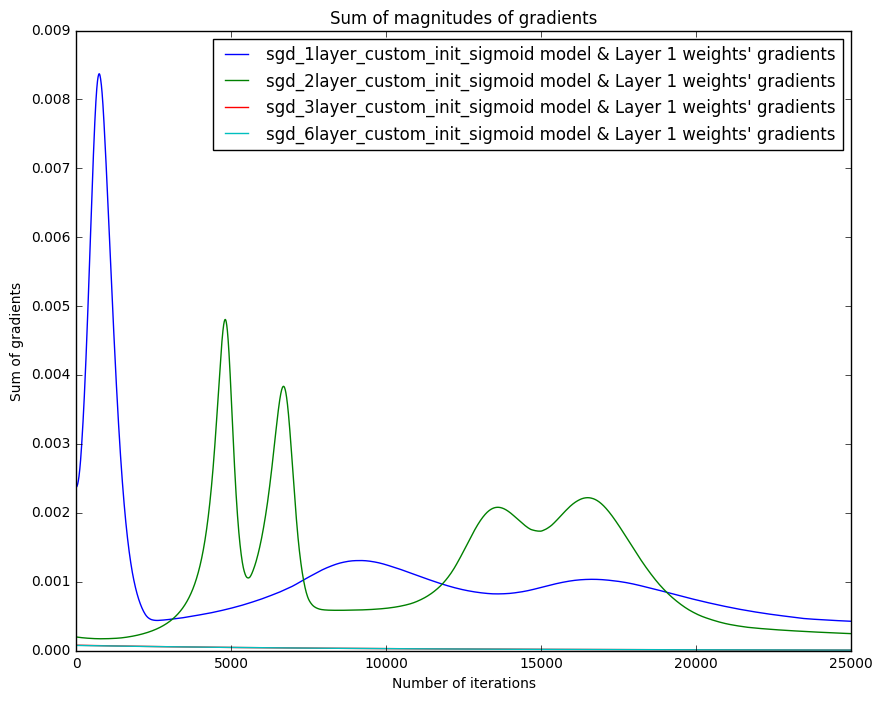

In [22]:
models = [sgd_1layer_custom_init_sigmoid,sgd_2layer_custom_init_sigmoid,sgd_3layer_custom_init_sigmoid, sgd_6layer_custom_init_sigmoid]
model_names = ["sgd_1layer_custom_init_sigmoid","sgd_2layer_custom_init_sigmoid","sgd_3layer_custom_init_sigmoid","sgd_6layer_custom_init_sigmoid"]
plot_gradients(models=models, model_names=model_names, layer_indices=[0])

### The effect of weights initialization on neural network training

#### Let's initialize all weights as zeros

In [23]:
sgd_4layer_zero_init = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*4), learning_rate=1e-1, 
                                        num_iterations=25000, W_init_type='zeros', activation_function='sigmoid')

#### Now train the model

In [26]:
sgd_4layer_zero_init.fit(X,y)

iteration 0: loss 1.098522
iteration 1000: loss 1.098522
iteration 2000: loss 1.098522
iteration 3000: loss 1.098523
iteration 4000: loss 1.098523
iteration 5000: loss 1.098523
iteration 6000: loss 1.098524
iteration 7000: loss 1.098524
iteration 8000: loss 1.098525
iteration 9000: loss 1.098525
iteration 10000: loss 1.098525
iteration 11000: loss 1.098526
iteration 12000: loss 1.098526
iteration 13000: loss 1.098526
iteration 14000: loss 1.098527
iteration 15000: loss 1.098527
iteration 16000: loss 1.098527
iteration 17000: loss 1.098528
iteration 18000: loss 1.098528
iteration 19000: loss 1.098528
iteration 20000: loss 1.098529
iteration 21000: loss 1.098529
iteration 22000: loss 1.098529
iteration 23000: loss 1.098530
iteration 24000: loss 1.098530


In [27]:
sgd_4layer_zero_init.accuracy(X,y)

training accuracy: 0.33


^^ So basically the weights aren't updated when they are initialized with zeros and the loss stays constant. This makes sense as essentially we have a constant function with zero gradient when the weights are all zeros.

#### Now let's initialize the weights using two popular techniques - Glorot/Xavier initialization and Kaiming initialization. 
http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf (Glorot/Xavier)

https://arxiv.org/abs/1502.01852 (Kaiming)

#### Glorot/Xavier initialization

In [28]:
sgd_1layer_glorot_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*1), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='glorot', activation_function='sigmoid', track_gradients=True)
sgd_1layer_glorot_sigmoid.fit(X,y)
sgd_1layer_glorot_sigmoid.accuracy(X,y)

iteration 0: loss 0.666450
iteration 1000: loss 0.833403
iteration 2000: loss 0.826954
iteration 3000: loss 0.826028
iteration 4000: loss 0.824908
iteration 5000: loss 0.823560
iteration 6000: loss 0.822085
iteration 7000: loss 0.820640
iteration 8000: loss 0.819341
iteration 9000: loss 0.818196
iteration 10000: loss 0.817065
iteration 11000: loss 0.815573
iteration 12000: loss 0.812834
iteration 13000: loss 0.807274
iteration 14000: loss 0.797690
iteration 15000: loss 0.785378
iteration 16000: loss 0.773474
iteration 17000: loss 0.763543
iteration 18000: loss 0.753818
iteration 19000: loss 0.741203
iteration 20000: loss 0.727132
iteration 21000: loss 0.716712
iteration 22000: loss 0.711619
iteration 23000: loss 0.710333
iteration 24000: loss 0.711078
training accuracy: 0.91


#### Kaiming initialization

In [29]:
sgd_1layer_kaiming_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*1), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='kaiming', activation_function='sigmoid', track_gradients=True)
sgd_1layer_kaiming_sigmoid.fit(X,y)
sgd_1layer_kaiming_sigmoid.accuracy(X,y)

iteration 0: loss 1.388669
iteration 1000: loss 0.839765
iteration 2000: loss 0.832673
iteration 3000: loss 0.825662
iteration 4000: loss 0.815406
iteration 5000: loss 0.799519
iteration 6000: loss 0.780659
iteration 7000: loss 0.765045
iteration 8000: loss 0.755130
iteration 9000: loss 0.748585
iteration 10000: loss 0.742032
iteration 11000: loss 0.734247
iteration 12000: loss 0.726699
iteration 13000: loss 0.721225
iteration 14000: loss 0.718248
iteration 15000: loss 0.717170
iteration 16000: loss 0.717200
iteration 17000: loss 0.717728
iteration 18000: loss 0.718381
iteration 19000: loss 0.718972
iteration 20000: loss 0.719431
iteration 21000: loss 0.719748
iteration 22000: loss 0.719938
iteration 23000: loss 0.720027
iteration 24000: loss 0.720041
training accuracy: 0.93


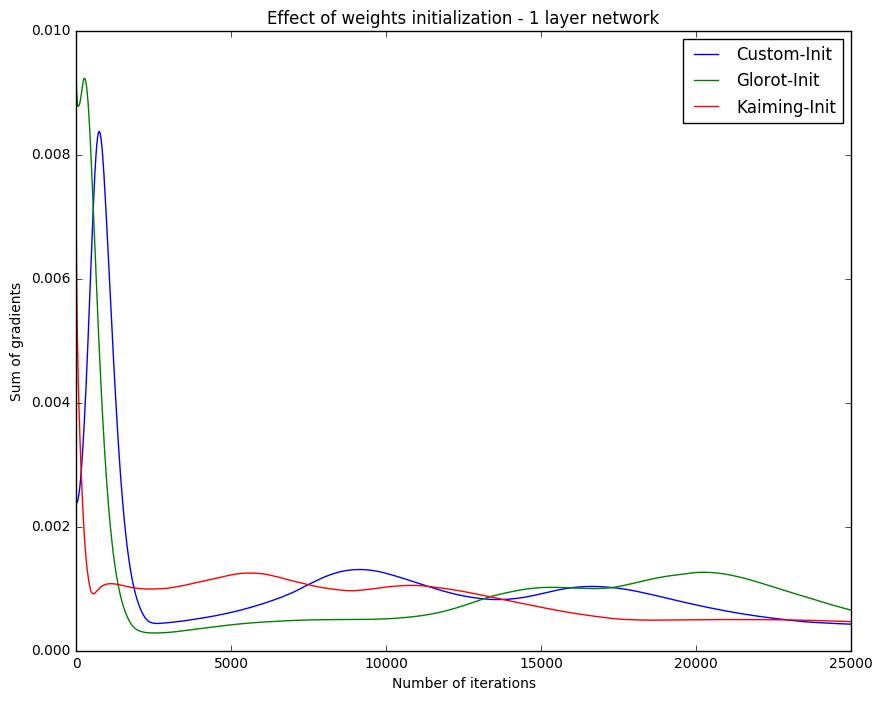

In [30]:
plot_gradients(models=[sgd_1layer_custom_init_sigmoid, sgd_1layer_glorot_sigmoid, sgd_1layer_kaiming_sigmoid], 
               custom_legend=['Custom-Init','Glorot-Init','Kaiming-Init'],
              title='Effect of weights initialization - 1 layer network')

In [31]:
sgd_2layer_glorot_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*2), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='glorot', activation_function='sigmoid', track_gradients=True)
sgd_2layer_glorot_sigmoid.fit(X,y)
sgd_2layer_glorot_sigmoid.accuracy(X,y)

iteration 0: loss 1.128873
iteration 1000: loss 0.972136
iteration 2000: loss 0.857982
iteration 3000: loss 0.852420
iteration 4000: loss 0.848198
iteration 5000: loss 0.844098
iteration 6000: loss 0.839374
iteration 7000: loss 0.832063
iteration 8000: loss 0.816311
iteration 9000: loss 0.781155
iteration 10000: loss 0.744357
iteration 11000: loss 0.721298
iteration 12000: loss 0.692722
iteration 13000: loss 0.662990
iteration 14000: loss 0.630910
iteration 15000: loss 0.613940
iteration 16000: loss 0.610513
iteration 17000: loss 0.611825
iteration 18000: loss 0.613650
iteration 19000: loss 0.614865
iteration 20000: loss 0.615446
iteration 21000: loss 0.615591
iteration 22000: loss 0.615477
iteration 23000: loss 0.615222
iteration 24000: loss 0.614901
training accuracy: 0.97


In [32]:
sgd_2layer_kaiming_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*2), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='kaiming', activation_function='sigmoid', track_gradients=True)
sgd_2layer_kaiming_sigmoid.fit(X,y)
sgd_2layer_kaiming_sigmoid.accuracy(X,y)

iteration 0: loss 0.946364
iteration 1000: loss 0.893240
iteration 2000: loss 0.872843
iteration 3000: loss 0.844316
iteration 4000: loss 0.781893
iteration 5000: loss 0.711665
iteration 6000: loss 0.670114
iteration 7000: loss 0.650134
iteration 8000: loss 0.642114
iteration 9000: loss 0.639688
iteration 10000: loss 0.638996
iteration 11000: loss 0.638520
iteration 12000: loss 0.637789
iteration 13000: loss 0.636747
iteration 14000: loss 0.635495
iteration 15000: loss 0.634173
iteration 16000: loss 0.632903
iteration 17000: loss 0.631749
iteration 18000: loss 0.630748
iteration 19000: loss 0.629938
iteration 20000: loss 0.629298
iteration 21000: loss 0.628746
iteration 22000: loss 0.628212
iteration 23000: loss 0.627659
iteration 24000: loss 0.627080
training accuracy: 0.97


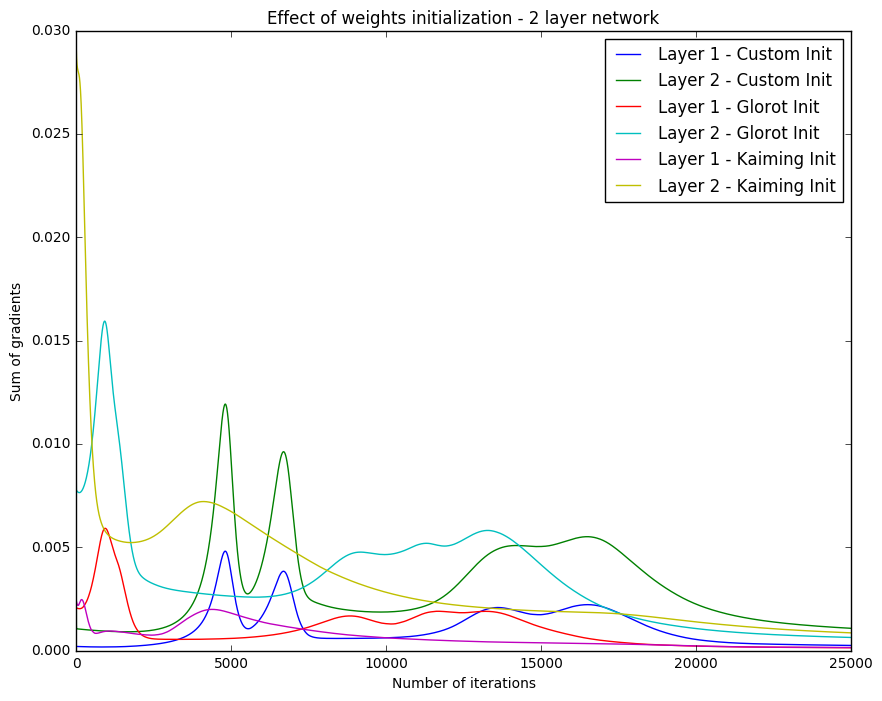

In [34]:
plot_gradients(models=[sgd_2layer_custom_init_sigmoid, sgd_2layer_glorot_sigmoid, sgd_2layer_kaiming_sigmoid], 
               custom_legend=['Layer 1 - Custom Init','Layer 2 - Custom Init',
                              'Layer 1 - Glorot Init','Layer 2 - Glorot Init',
                              'Layer 1 - Kaiming Init','Layer 2 - Kaiming Init'],
               title='Effect of weights initialization - 2 layer network', axes_limits=[0,25000,0,0.03])

In [37]:
sgd_3layer_glorot_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*3), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='glorot', activation_function='sigmoid', track_gradients=True)
sgd_3layer_glorot_sigmoid.fit(X,y)
sgd_3layer_glorot_sigmoid.accuracy(X,y)

iteration 0: loss 0.653283
iteration 1000: loss 1.140008
iteration 2000: loss 1.120336
iteration 3000: loss 0.976117
iteration 4000: loss 0.926971
iteration 5000: loss 0.870700
iteration 6000: loss 0.865431
iteration 7000: loss 0.860071
iteration 8000: loss 0.852936
iteration 9000: loss 0.838259
iteration 10000: loss 0.792779
iteration 11000: loss 0.698362
iteration 12000: loss 0.596500
iteration 13000: loss 0.565011
iteration 14000: loss 0.558083
iteration 15000: loss 0.555664
iteration 16000: loss 0.554000
iteration 17000: loss 0.552380
iteration 18000: loss 0.550764
iteration 19000: loss 0.549205
iteration 20000: loss 0.547727
iteration 21000: loss 0.546331
iteration 22000: loss 0.545012
iteration 23000: loss 0.543770
iteration 24000: loss 0.542612
training accuracy: 0.99


In [38]:
sgd_3layer_kaiming_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*3), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='kaiming', activation_function='sigmoid', track_gradients=True)
sgd_3layer_kaiming_sigmoid.fit(X,y)
sgd_3layer_kaiming_sigmoid.accuracy(X,y)

iteration 0: loss 0.722474
iteration 1000: loss 0.951140
iteration 2000: loss 0.920895
iteration 3000: loss 0.884462
iteration 4000: loss 0.792300
iteration 5000: loss 0.731672
iteration 6000: loss 0.703605
iteration 7000: loss 0.659736
iteration 8000: loss 0.616724
iteration 9000: loss 0.597660
iteration 10000: loss 0.589817
iteration 11000: loss 0.585159
iteration 12000: loss 0.581522
iteration 13000: loss 0.578408
iteration 14000: loss 0.575613
iteration 15000: loss 0.572983
iteration 16000: loss 0.570409
iteration 17000: loss 0.567832
iteration 18000: loss 0.565249
iteration 19000: loss 0.562706
iteration 20000: loss 0.560275
iteration 21000: loss 0.558006
iteration 22000: loss 0.555893
iteration 23000: loss 0.553910
iteration 24000: loss 0.552048
training accuracy: 0.99


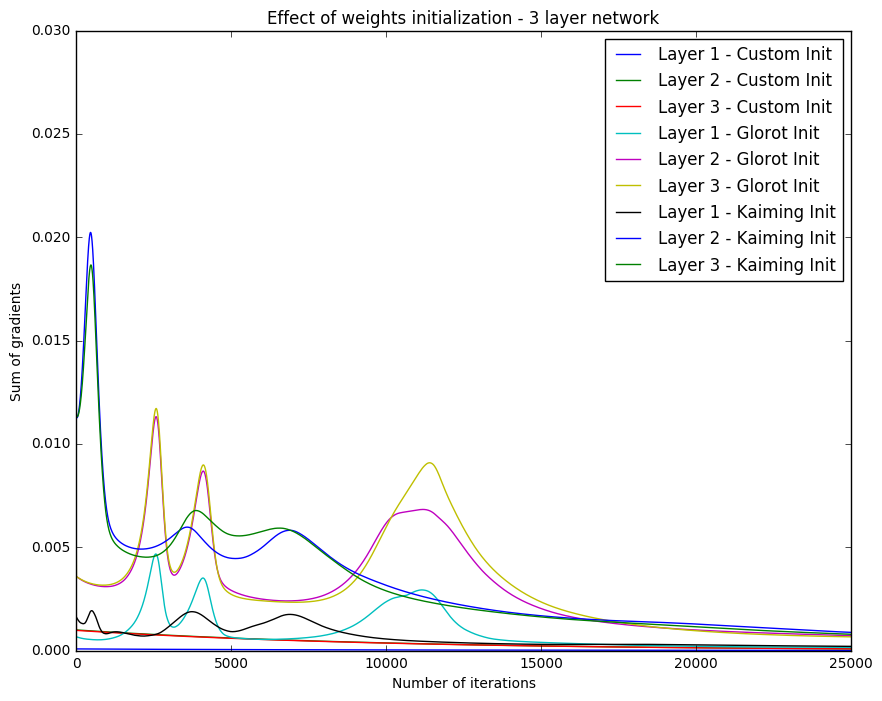

In [41]:
plot_gradients(models=[sgd_3layer_custom_init_sigmoid, sgd_3layer_glorot_sigmoid, sgd_3layer_kaiming_sigmoid], 
               custom_legend=['Layer 1 - Custom Init','Layer 2 - Custom Init','Layer 3 - Custom Init',
                              'Layer 1 - Glorot Init','Layer 2 - Glorot Init','Layer 3 - Glorot Init',
                              'Layer 1 - Kaiming Init','Layer 2 - Kaiming Init','Layer 3 - Kaiming Init'],
               title='Effect of weights initialization - 3 layer network', axes_limits=[0,25000,0,0.03])

### Let's just focus on the last layer

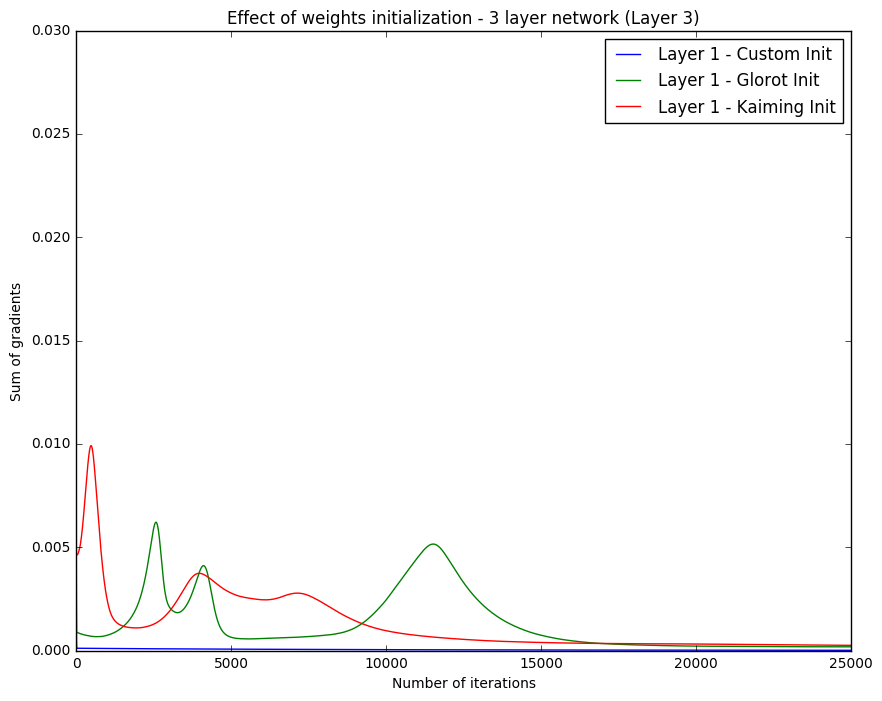

In [43]:
plot_gradients(models=[sgd_3layer_custom_init_sigmoid, sgd_3layer_glorot_sigmoid, sgd_3layer_kaiming_sigmoid], 
               custom_legend=['Layer 1 - Custom Init','Layer 1 - Glorot Init','Layer 1 - Kaiming Init'],
               title='Effect of weights initialization - 3 layer network (Layer 3)', axes_limits=[0,25000,0,0.03],layer_indices=[3])

In [35]:
sgd_6layer_kaiming_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*6), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='kaiming', activation_function='sigmoid', track_gradients=True)
sgd_6layer_kaiming_sigmoid.fit(X,y)
sgd_6layer_kaiming_sigmoid.accuracy(X,y)

iteration 0: loss 1.322331
iteration 1000: loss 1.352970
iteration 2000: loss 1.306780
iteration 3000: loss 1.269035
iteration 4000: loss 1.238144
iteration 5000: loss 1.212850
iteration 6000: loss 1.192135
iteration 7000: loss 1.175171
iteration 8000: loss 1.161280
iteration 9000: loss 1.149905
iteration 10000: loss 1.140591
iteration 11000: loss 1.132966
iteration 12000: loss 1.126722
iteration 13000: loss 1.121611
iteration 14000: loss 1.117425
iteration 15000: loss 1.113999
iteration 16000: loss 1.111194
iteration 17000: loss 1.108897
iteration 18000: loss 1.107017
iteration 19000: loss 1.105478
iteration 20000: loss 1.104218
iteration 21000: loss 1.103186
iteration 22000: loss 1.102341
iteration 23000: loss 1.101650
iteration 24000: loss 1.101084
training accuracy: 0.33


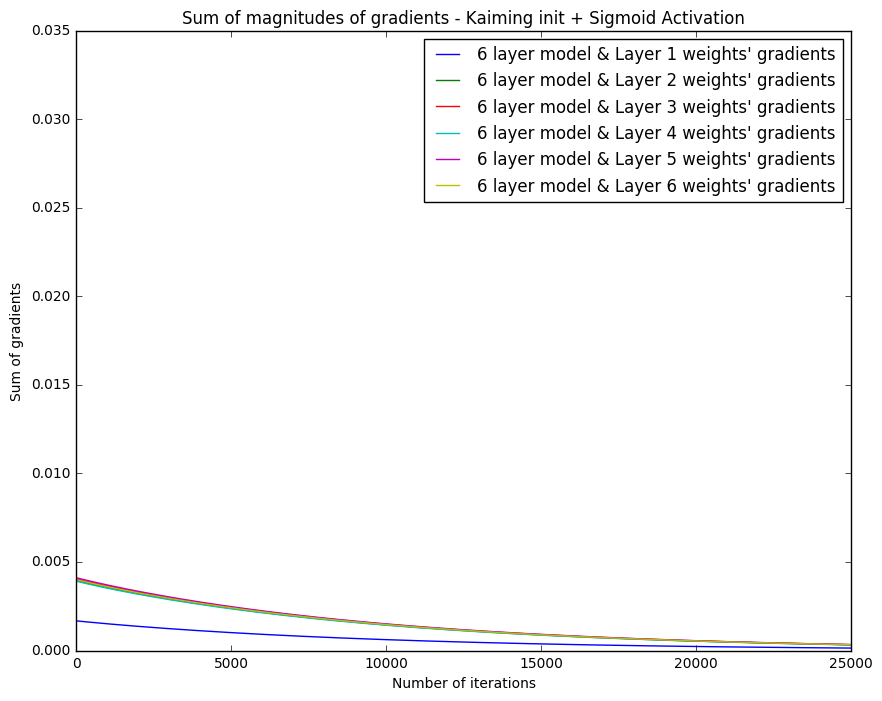

In [36]:
plot_gradients(models=[sgd_6layer_kaiming_sigmoid], title="Sum of magnitudes of gradients - Kaiming init + Sigmoid Activation")

### Conclusion: We observe that robust initialization leads to better convergence and training error rates. However, if we increase the depth of the network beyond a certain limit, then we end up not taking the advantage of the good initialization.

### Let's now tune another parameter - the activation function of the hidden layers.
### Let's repeat some of the above experiments with ReLU activation.

To start with, let's take the 6 layer model above and switch it to use ReLU instead of sigmoid activations

In [44]:
sgd_6layer_kaiming_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*6), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='kaiming', activation_function='relu', track_gradients=True)
sgd_6layer_kaiming_relu.fit(X,y)
sgd_6layer_kaiming_relu.accuracy(X,y)

iteration 0: loss 1.188563
iteration 1000: loss 0.294311
iteration 2000: loss 0.251066
iteration 3000: loss 0.223160
iteration 4000: loss 0.192286
iteration 5000: loss 0.172360
iteration 6000: loss 0.152527
iteration 7000: loss 0.151680
iteration 8000: loss 0.126257
iteration 9000: loss 0.127429
iteration 10000: loss 0.142130
iteration 11000: loss 0.110432
iteration 12000: loss 0.104783
iteration 13000: loss 0.139214
iteration 14000: loss 0.096226
iteration 15000: loss 0.091208
iteration 16000: loss 0.087879
iteration 17000: loss 0.086812
iteration 18000: loss 0.084653
iteration 19000: loss 0.084000
iteration 20000: loss 0.081568
iteration 21000: loss 0.079473
iteration 22000: loss 0.076159
iteration 23000: loss 0.078028
iteration 24000: loss 0.079951
training accuracy: 0.99


In [45]:
sgd_6layer_glorot_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*6), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='glorot', activation_function='relu', track_gradients=True)
sgd_6layer_glorot_relu.fit(X,y)
sgd_6layer_glorot_relu.accuracy(X,y)

iteration 0: loss 0.825664
iteration 1000: loss 0.188320
iteration 2000: loss 0.175789
iteration 3000: loss 0.164058
iteration 4000: loss 0.152500
iteration 5000: loss 0.129509
iteration 6000: loss 0.120078
iteration 7000: loss 0.108643
iteration 8000: loss 0.105656
iteration 9000: loss 0.100406
iteration 10000: loss 0.099217
iteration 11000: loss 0.088640
iteration 12000: loss 0.083667
iteration 13000: loss 0.087949
iteration 14000: loss 0.080828
iteration 15000: loss 0.081454
iteration 16000: loss 0.078998
iteration 17000: loss 0.075266
iteration 18000: loss 0.080329
iteration 19000: loss 0.075509
iteration 20000: loss 0.073745
iteration 21000: loss 0.071697
iteration 22000: loss 0.072700
iteration 23000: loss 0.073354
iteration 24000: loss 0.073785
training accuracy: 0.98


#### As always, be careful with the initialization :)

In [46]:
sgd_6layer_custom_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*6), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='0.05_sigma', activation_function='relu', track_gradients=True)
sgd_6layer_custom_relu.fit(X,y)
sgd_6layer_custom_relu.accuracy(X,y)

iteration 0: loss 0.709268
iteration 1000: loss 1.111704
iteration 2000: loss 1.109321
iteration 3000: loss 1.107370
iteration 4000: loss 1.105773
iteration 5000: loss 1.104466
iteration 6000: loss 1.103396
iteration 7000: loss 1.102521
iteration 8000: loss 1.101806
iteration 9000: loss 1.101220
iteration 10000: loss 1.100741
iteration 11000: loss 1.100350
iteration 12000: loss 1.100030
iteration 13000: loss 1.099769
iteration 14000: loss 1.099555
iteration 15000: loss 1.099380
iteration 16000: loss 1.099238
iteration 17000: loss 1.099121
iteration 18000: loss 1.099026
iteration 19000: loss 1.098948
iteration 20000: loss 1.098885
iteration 21000: loss 1.098834
iteration 22000: loss 1.098791
iteration 23000: loss 1.098757
iteration 24000: loss 1.098729
training accuracy: 0.33


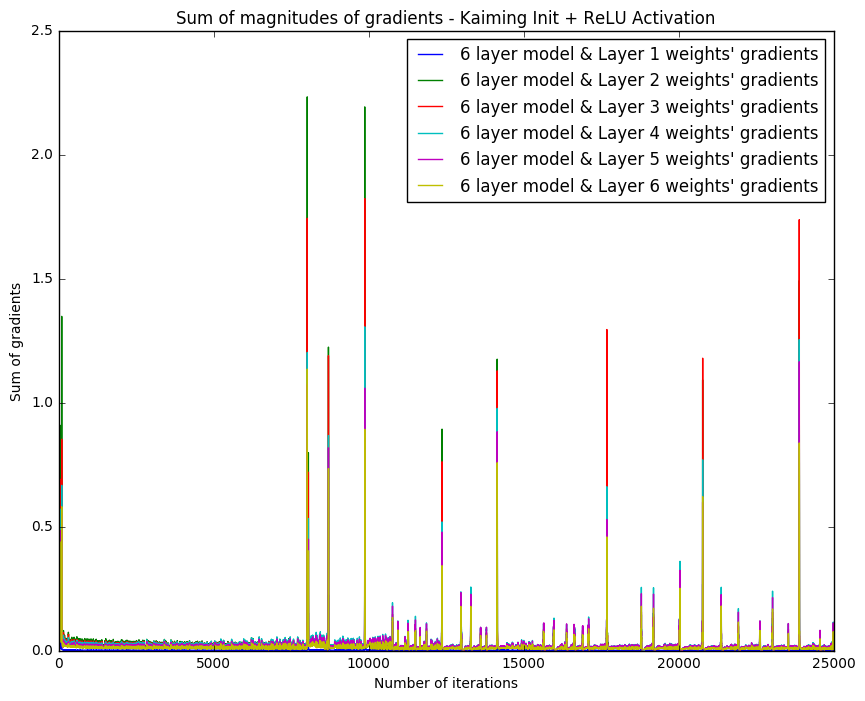

In [47]:
plot_gradients(models=[sgd_6layer_kaiming_relu],title="Sum of magnitudes of gradients - Kaiming Init + ReLU Activation")

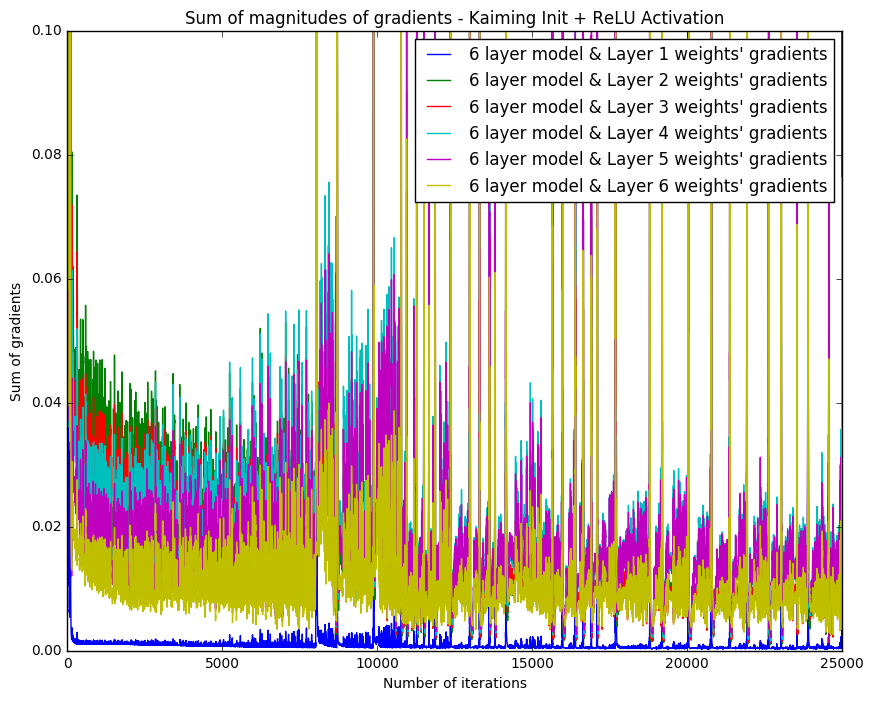

In [49]:
plot_gradients(models=[sgd_6layer_kaiming_relu],title="Sum of magnitudes of gradients - Kaiming Init + ReLU Activation",
              axes_limits=[0,25000,0,0.1])

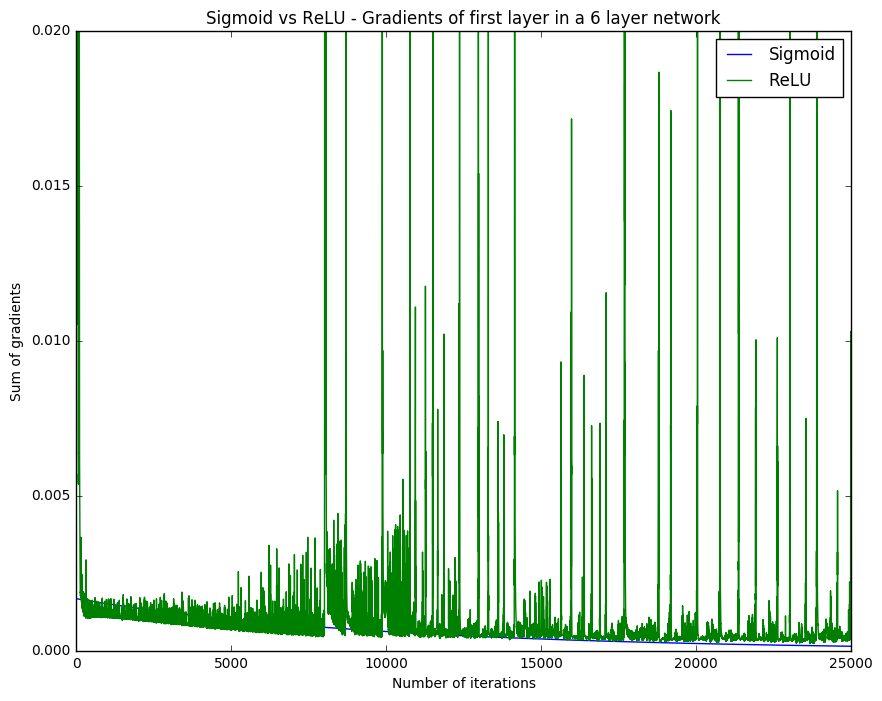

In [51]:
plot_gradients(models=[sgd_6layer_kaiming_sigmoid,sgd_6layer_kaiming_relu],layer_indices=[0],
               custom_legend=['Sigmoid','ReLU'], title='Sigmoid vs ReLU - Gradients of first layer in a 6 layer network',
              axes_limits=[0,25000,0,0.02])

In [52]:
sgd_1layer_kaiming_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*1), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='kaiming', activation_function='relu', track_gradients=True)
sgd_1layer_kaiming_relu.fit(X,y)
sgd_1layer_kaiming_relu.accuracy(X,y)

iteration 0: loss 0.775349
iteration 1000: loss 0.422609
iteration 2000: loss 0.366343
iteration 3000: loss 0.358267
iteration 4000: loss 0.358755
iteration 5000: loss 0.360540
iteration 6000: loss 0.362581
iteration 7000: loss 0.364094
iteration 8000: loss 0.365283
iteration 9000: loss 0.366100
iteration 10000: loss 0.366657
iteration 11000: loss 0.367042
iteration 12000: loss 0.367323
iteration 13000: loss 0.367537
iteration 14000: loss 0.367688
iteration 15000: loss 0.367798
iteration 16000: loss 0.367856
iteration 17000: loss 0.367887
iteration 18000: loss 0.367926
iteration 19000: loss 0.367949
iteration 20000: loss 0.367962
iteration 21000: loss 0.367960
iteration 22000: loss 0.367940
iteration 23000: loss 0.367949
iteration 24000: loss 0.367962
training accuracy: 0.99


In [53]:
sgd_1layer_glorot_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*1), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='glorot', activation_function='relu', track_gradients=True)
sgd_1layer_glorot_relu.fit(X,y)
sgd_1layer_glorot_relu.accuracy(X,y)

iteration 0: loss 0.704632
iteration 1000: loss 0.626629
iteration 2000: loss 0.461006
iteration 3000: loss 0.394850
iteration 4000: loss 0.369356
iteration 5000: loss 0.362506
iteration 6000: loss 0.362137
iteration 7000: loss 0.363591
iteration 8000: loss 0.364842
iteration 9000: loss 0.365967
iteration 10000: loss 0.366949
iteration 11000: loss 0.367634
iteration 12000: loss 0.368135
iteration 13000: loss 0.368269
iteration 14000: loss 0.368354
iteration 15000: loss 0.368360
iteration 16000: loss 0.368314
iteration 17000: loss 0.368246
iteration 18000: loss 0.368196
iteration 19000: loss 0.368169
iteration 20000: loss 0.368151
iteration 21000: loss 0.368131
iteration 22000: loss 0.368139
iteration 23000: loss 0.368149
iteration 24000: loss 0.368154
training accuracy: 0.99


In [54]:
sgd_1layer_custom_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*1), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='0.05_sigma', activation_function='relu', track_gradients=True)
sgd_1layer_custom_relu.fit(X,y)
sgd_1layer_custom_relu.accuracy(X,y)

iteration 0: loss 0.693921
iteration 1000: loss 0.751435
iteration 2000: loss 0.623879
iteration 3000: loss 0.508752
iteration 4000: loss 0.459971
iteration 5000: loss 0.404597
iteration 6000: loss 0.375796
iteration 7000: loss 0.366855
iteration 8000: loss 0.365704
iteration 9000: loss 0.366625
iteration 10000: loss 0.367785
iteration 11000: loss 0.368799
iteration 12000: loss 0.369547
iteration 13000: loss 0.370065
iteration 14000: loss 0.370384
iteration 15000: loss 0.370574
iteration 16000: loss 0.370656
iteration 17000: loss 0.370642
iteration 18000: loss 0.370595
iteration 19000: loss 0.370529
iteration 20000: loss 0.370427
iteration 21000: loss 0.370339
iteration 22000: loss 0.370266
iteration 23000: loss 0.370206
iteration 24000: loss 0.370147
training accuracy: 0.99


In [55]:
sgd_2layer_kaiming_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*2), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='kaiming', activation_function='relu', track_gradients=True)
sgd_2layer_kaiming_relu.fit(X,y)
sgd_2layer_kaiming_relu.accuracy(X,y)

iteration 0: loss 0.871290
iteration 1000: loss 0.220979
iteration 2000: loss 0.206540
iteration 3000: loss 0.200157
iteration 4000: loss 0.195172
iteration 5000: loss 0.190902
iteration 6000: loss 0.187303
iteration 7000: loss 0.184287
iteration 8000: loss 0.181725
iteration 9000: loss 0.179577
iteration 10000: loss 0.177747
iteration 11000: loss 0.176200
iteration 12000: loss 0.174896
iteration 13000: loss 0.173769
iteration 14000: loss 0.172811
iteration 15000: loss 0.171989
iteration 16000: loss 0.171251
iteration 17000: loss 0.170589
iteration 18000: loss 0.169998
iteration 19000: loss 0.169480
iteration 20000: loss 0.169030
iteration 21000: loss 0.168596
iteration 22000: loss 0.168204
iteration 23000: loss 0.167853
iteration 24000: loss 0.167529
training accuracy: 0.99


In [56]:
sgd_3layer_kaiming_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*3), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='kaiming', activation_function='relu', track_gradients=True)
sgd_3layer_kaiming_relu.fit(X,y)
sgd_3layer_kaiming_relu.accuracy(X,y)

iteration 0: loss 0.803278
iteration 1000: loss 0.210635
iteration 2000: loss 0.191477
iteration 3000: loss 0.176664
iteration 4000: loss 0.164628
iteration 5000: loss 0.154886
iteration 6000: loss 0.146962
iteration 7000: loss 0.140565
iteration 8000: loss 0.135361
iteration 9000: loss 0.131121
iteration 10000: loss 0.127832
iteration 11000: loss 0.125156
iteration 12000: loss 0.122745
iteration 13000: loss 0.120604
iteration 14000: loss 0.118958
iteration 15000: loss 0.117550
iteration 16000: loss 0.116380
iteration 17000: loss 0.115277
iteration 18000: loss 0.114350
iteration 19000: loss 0.113564
iteration 20000: loss 0.112823
iteration 21000: loss 0.112193
iteration 22000: loss 0.111478
iteration 23000: loss 0.111057
iteration 24000: loss 0.110411
training accuracy: 0.99


In [57]:
sgd_3layer_glorot_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*3), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='glorot', activation_function='relu', track_gradients=True)
sgd_3layer_glorot_relu.fit(X,y)
sgd_3layer_glorot_relu.accuracy(X,y)

iteration 0: loss 0.777096
iteration 1000: loss 0.164304
iteration 2000: loss 0.146456
iteration 3000: loss 0.140423
iteration 4000: loss 0.135894
iteration 5000: loss 0.131518
iteration 6000: loss 0.128317
iteration 7000: loss 0.125116
iteration 8000: loss 0.123394
iteration 9000: loss 0.120587
iteration 10000: loss 0.119086
iteration 11000: loss 0.117016
iteration 12000: loss 0.116087
iteration 13000: loss 0.114694
iteration 14000: loss 0.113324
iteration 15000: loss 0.112874
iteration 16000: loss 0.111708
iteration 17000: loss 0.111320
iteration 18000: loss 0.111834
iteration 19000: loss 0.110538
iteration 20000: loss 0.109662
iteration 21000: loss 0.109589
iteration 22000: loss 0.109450
iteration 23000: loss 0.108829
iteration 24000: loss 0.108467
training accuracy: 0.99


In [58]:
sgd_3layer_custom_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*3), learning_rate=1e-1, num_iterations=25000,
                                               W_init_type='0.05_sigma', activation_function='relu', track_gradients=True)
sgd_3layer_custom_relu.fit(X,y)
sgd_3layer_custom_relu.accuracy(X,y)

iteration 0: loss 0.699645
iteration 1000: loss 0.694973
iteration 2000: loss 0.143494
iteration 3000: loss 0.135622
iteration 4000: loss 0.127434
iteration 5000: loss 0.119195
iteration 6000: loss 0.121179
iteration 7000: loss 0.118059
iteration 8000: loss 0.117531
iteration 9000: loss 0.116277
iteration 10000: loss 0.115306
iteration 11000: loss 0.113614
iteration 12000: loss 0.113662
iteration 13000: loss 0.113228
iteration 14000: loss 0.114137
iteration 15000: loss 0.112771
iteration 16000: loss 0.110187
iteration 17000: loss 0.110524
iteration 18000: loss 0.110594
iteration 19000: loss 0.109430
iteration 20000: loss 0.108277
iteration 21000: loss 0.108437
iteration 22000: loss 0.107891
iteration 23000: loss 0.107618
iteration 24000: loss 0.109050
training accuracy: 0.99


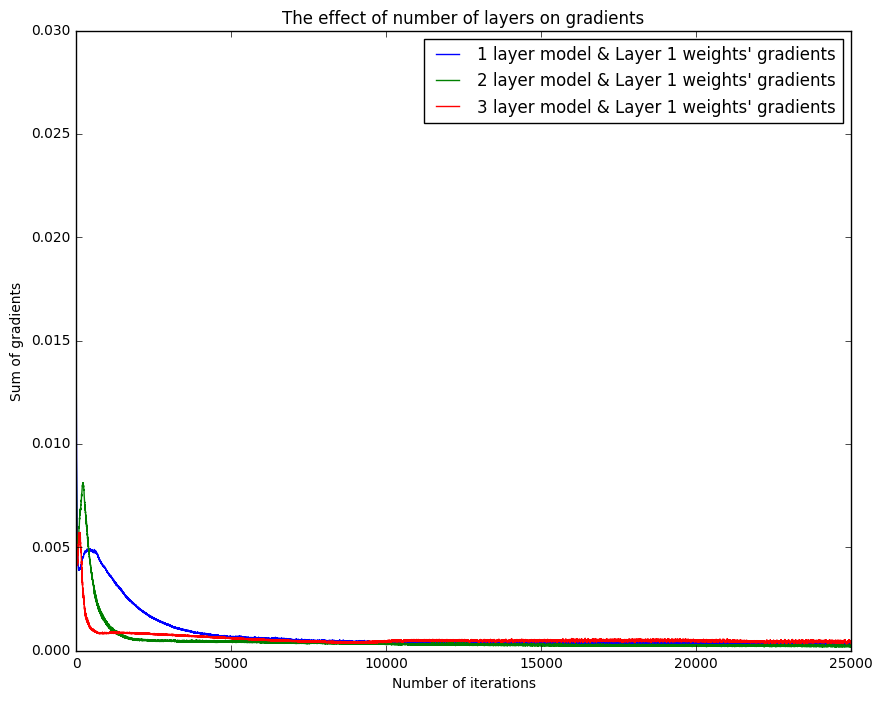

In [62]:
plot_gradients(models=[sgd_1layer_kaiming_relu, sgd_2layer_kaiming_relu, sgd_3layer_kaiming_relu],
               layer_indices=[0],
               title="The effect of number of layers on gradients", axes_limits=[0,25000,0,0.03])

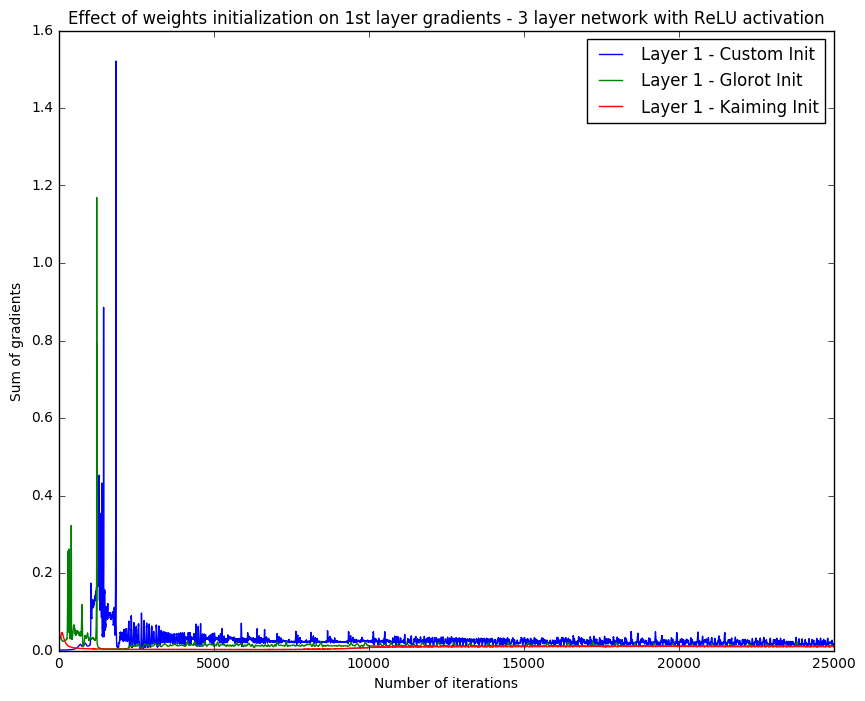

In [66]:
plot_gradients(models=[sgd_3layer_custom_relu, sgd_3layer_glorot_relu, sgd_3layer_kaiming_relu], 
               layer_indices=[2],
               custom_legend=['Layer 1 - Custom Init',
                              'Layer 1 - Glorot Init',
                              'Layer 1 - Kaiming Init'],
               title='Effect of weights initialization on 1st layer gradients - 3 layer network with ReLU activation')

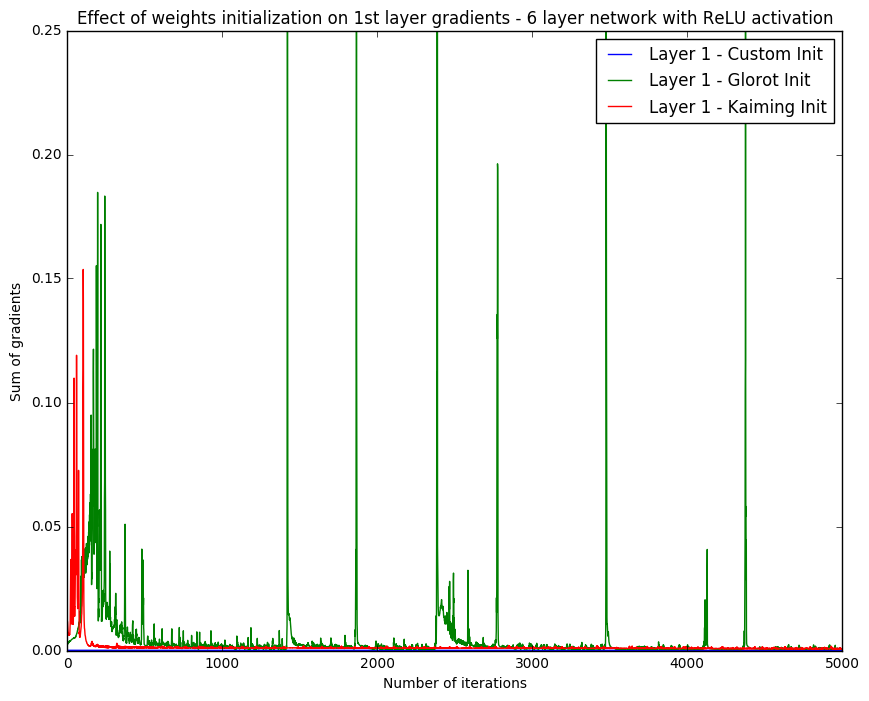

In [67]:
plot_gradients(models=[sgd_6layer_custom_relu, sgd_6layer_glorot_relu, sgd_6layer_kaiming_relu], 
               layer_indices=[0],
               custom_legend=['Layer 1 - Custom Init',
                              'Layer 1 - Glorot Init',
                              'Layer 1 - Kaiming Init'],
               title='Effect of weights initialization on 1st layer gradients - 6 layer network with ReLU activation',
              axes_limits=[0,5000,0,0.25])

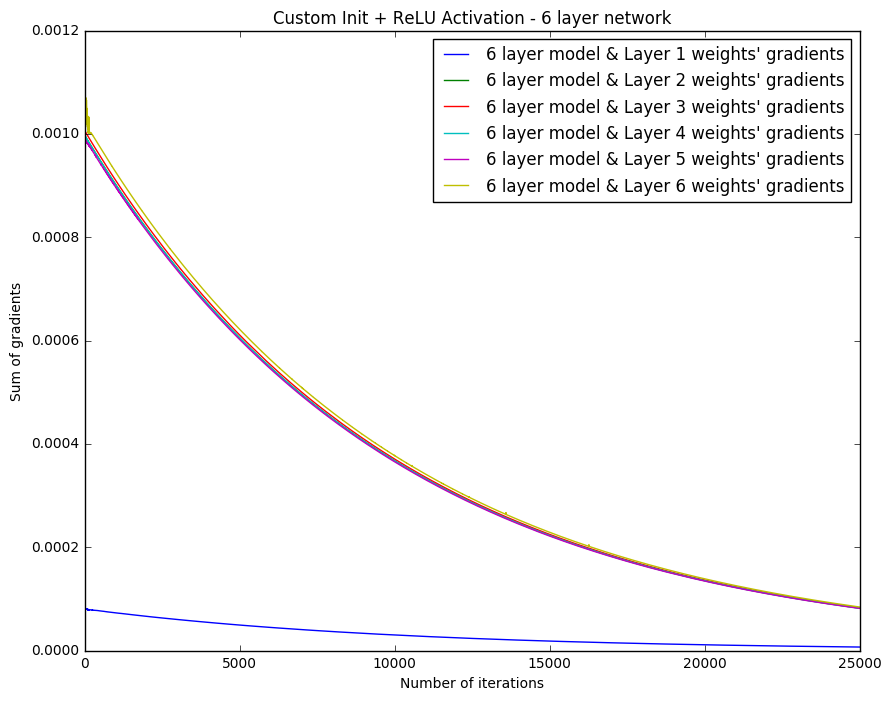

In [69]:
plot_gradients(models=[sgd_6layer_custom_relu], title="Custom Init + ReLU Activation - 6 layer network")

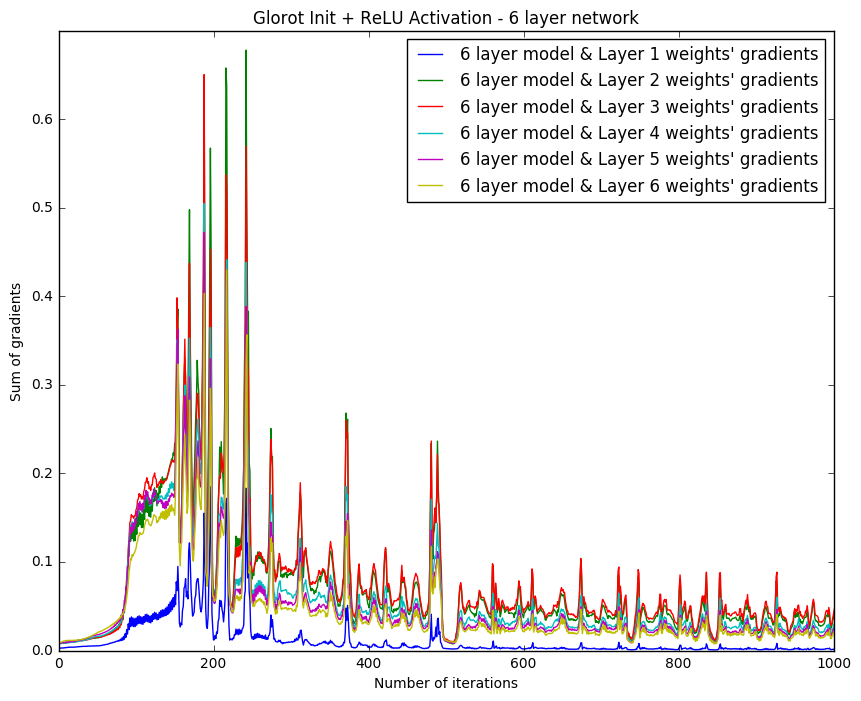

In [70]:
plot_gradients(models=[sgd_6layer_glorot_relu], title="Glorot Init + ReLU Activation - 6 layer network", axes_limits=[0,1000,0,0.7])

### A few observations:
    - We finally see the desired effect that the performance of the model improves as we increase the number of layers
    - The convergence rate with ReLU is higher than that with sigmoid activation
    - There is not always a "winning" parameter combination. It is useful to plot things like above for different parameters of the network inorder to achieve the ideal result
    - On a similar note, it is the combination of parameters that matter and not any specific individual parameter. For instance, a 6-layer network with bad initialization but ReLU activations (sgd_6layer_custom_relu) on hidden layers is equally worse as a 6-layer network with good initialization and sigmoid activations (sgd_6layer_kaiming_sigmoid). To achieve the best performance, we needed a 6-layer network with good initialization and ReLU activations (sgd_6layer_kaiming_relu).